In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# libraries that get the data cifar-10
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
# libraries that handle unstrcture data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# evaluation metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


<ipython-input-7-73a71000417b>:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


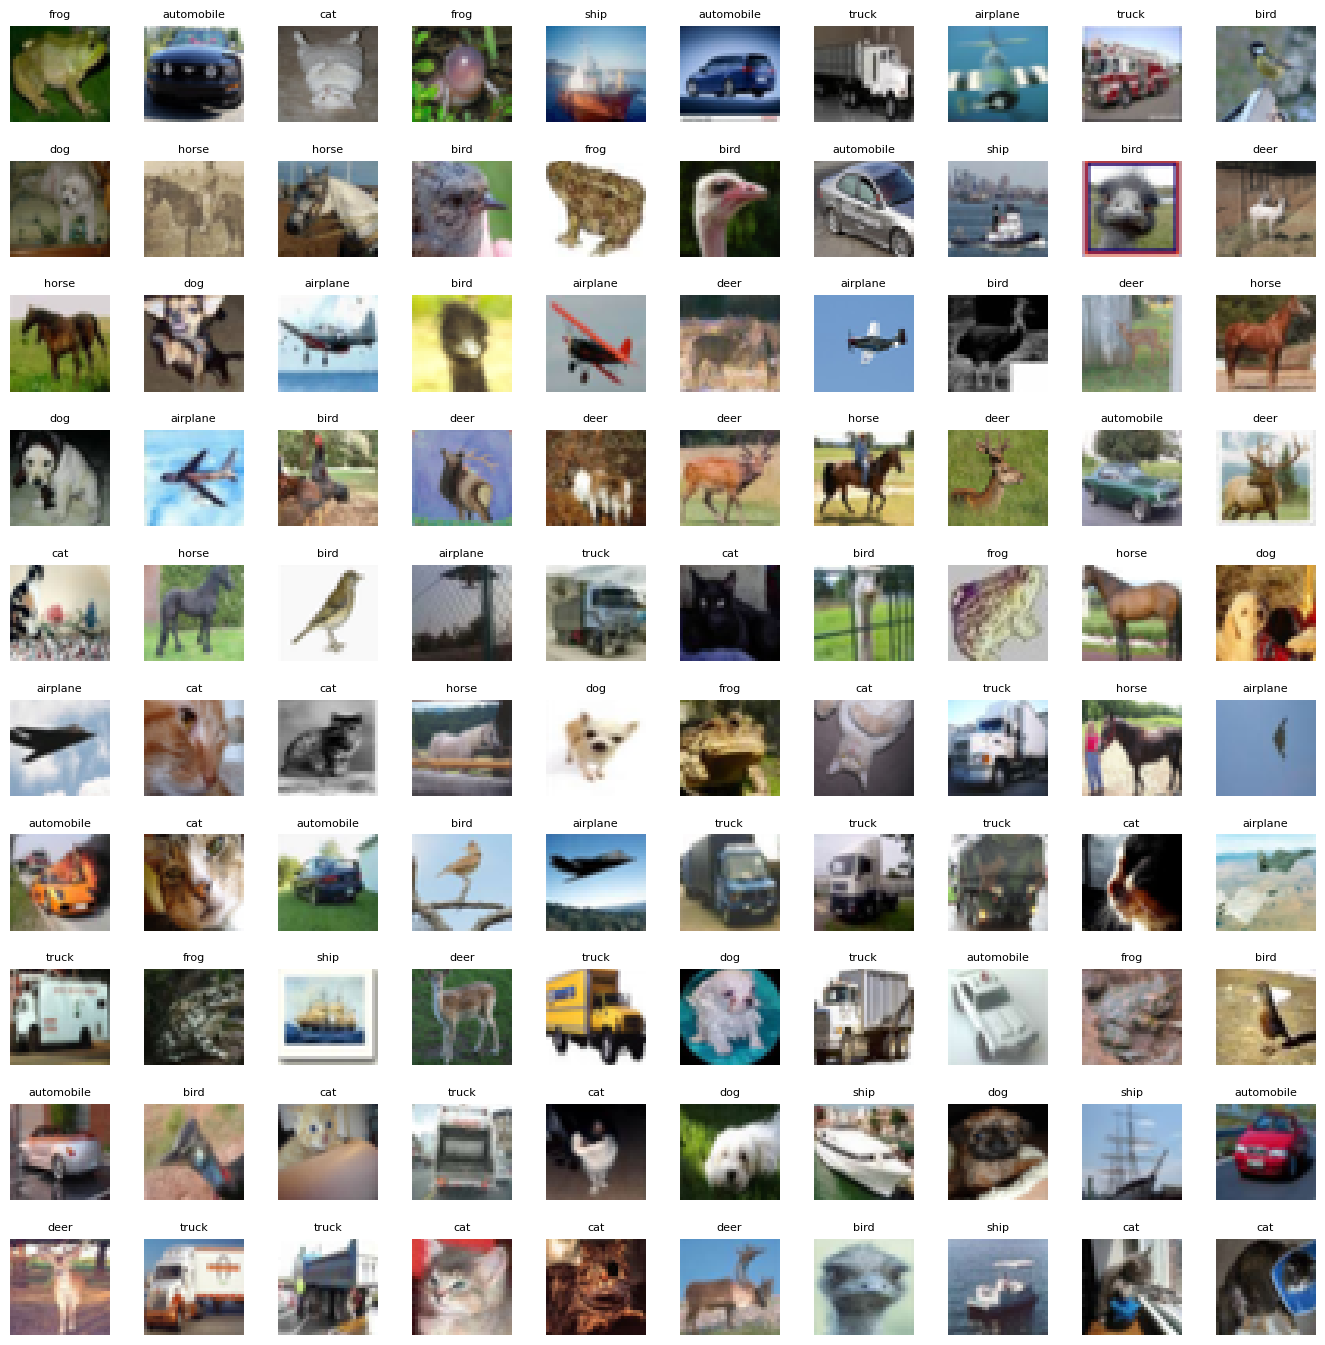

In [7]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

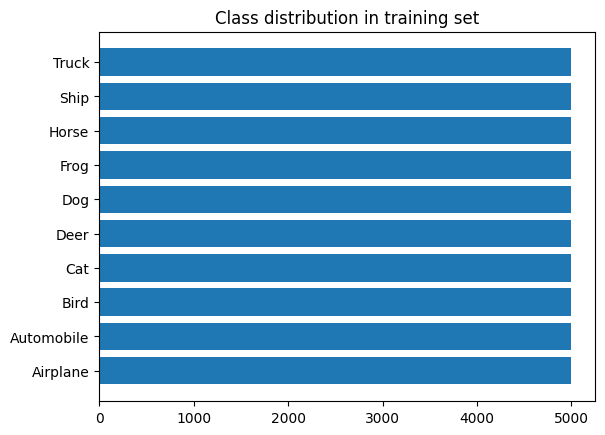

In [8]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

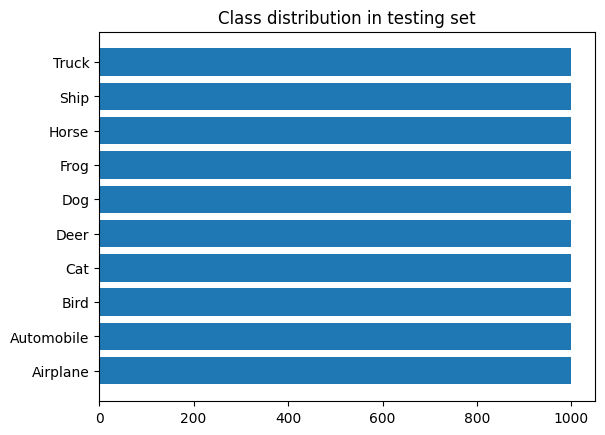

In [9]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

The class are equally distributed

In [10]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [11]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
# Define input shape and kernel size
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)

# Initialize the Sequential model
model = Sequential()

# Layer configurations: (filters, repeat_count)
conv_layers = [
    (32, 2),
    (64, 2),
    (128, 2)
]

# Add convolutional layers
for filters, repeat_count in conv_layers:
    for i in range(repeat_count):
        if i == 0:  # Only set input_shape for the first layer in each block
            model.add(Conv2D(filters=filters, kernel_size=KERNEL_SIZE, activation='relu', padding='same', input_shape=INPUT_SHAPE))
        else:
            model.add(Conv2D(filters=filters, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
        model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

# Flatten the output before the dense layers
model.add(Flatten())

# Dense layer configurations: (units, dropout_rate)
dense_layers = [
    (128, 0.25),
    (10, None)  # Final layer with no dropout
]

# Add dense layers
for units, dropout_rate in dense_layers:
    model.add(Dense(units, activation='relu' if units != 10 else 'softmax'))
    if dropout_rate:
        model.add(Dropout(dropout_rate))

# Define metrics for model evaluation
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

# Summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [13]:
# number of samples that processed in one go is 32
batch_size = 32
# creating a data geneator
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# Creating the Training Data Generator
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
# Calculating Steps Per Epoch
steps_per_epoch = X_train.shape[0] // batch_size
steps_per_epoch
r = model.fit(train_generator,
              epochs=20,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test)
             )

Epoch 1/20
1562/1562 [==============================] - 57s 31ms/step - loss: 1.6466 - accuracy: 0.4051 - precision: 0.6296 - recall: 0.1926 - val_loss: 1.4112 - val_accuracy: 0.4918 - val_precision: 0.6245 - val_recall: 0.3744
Epoch 2/20
1562/1562 [==============================] - 47s 30ms/step - loss: 1.2317 - accuracy: 0.5631 - precision: 0.7308 - recall: 0.3957 - val_loss: 1.0562 - val_accuracy: 0.6350 - val_precision: 0.7534 - val_recall: 0.5105
Epoch 3/20
1562/1562 [==============================] - 47s 30ms/step - loss: 1.0436 - accuracy: 0.6381 - precision: 0.7714 - recall: 0.5044 - val_loss: 0.9906 - val_accuracy: 0.6673 - val_precision: 0.7479 - val_recall: 0.5874
Epoch 4/20
1562/1562 [==============================] - 46s 29ms/step - loss: 0.9344 - accuracy: 0.6795 - precision: 0.7922 - recall: 0.5658 - val_loss: 0.7625 - val_accuracy: 0.7374 - val_precision: 0.8195 - val_recall: 0.6543
Epoch 5/20
1562/1562 [==============================] - 46s 30ms/step - loss: 0.8600 - a

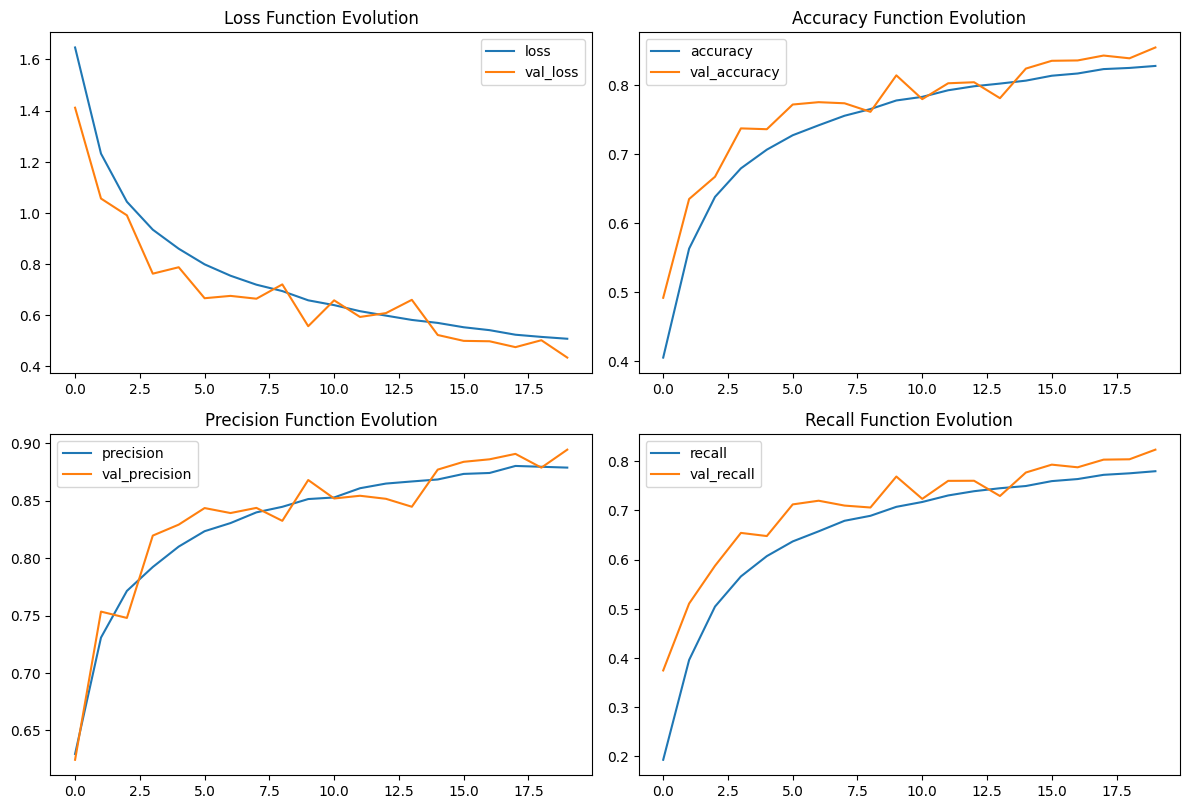

In [14]:
# Define the metrics and their titles
metrics = ['loss', 'accuracy', 'precision', 'recall']
titles = ['Loss Function Evolution', 'Accuracy Function Evolution',
          'Precision Function Evolution', 'Recall Function Evolution']

# Create a figure with specified size
plt.figure(figsize=(12, 16))

# Loop through the metrics and plot each one
for i, metric in enumerate(metrics):
    plt.subplot(4, 2, i + 1)
    plt.plot(r.history[metric], label=metric)
    plt.plot(r.history[f'val_{metric}'], label=f'val_{metric}')
    plt.title(titles[i])
    plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

313/313 [==============================] - 1s 4ms/step - loss: 0.4344 - accuracy: 0.8547 - precision: 0.8943 - recall: 0.8237
Test Accuracy : 85.47%
313/313 [==============================] - 1s 4ms/step


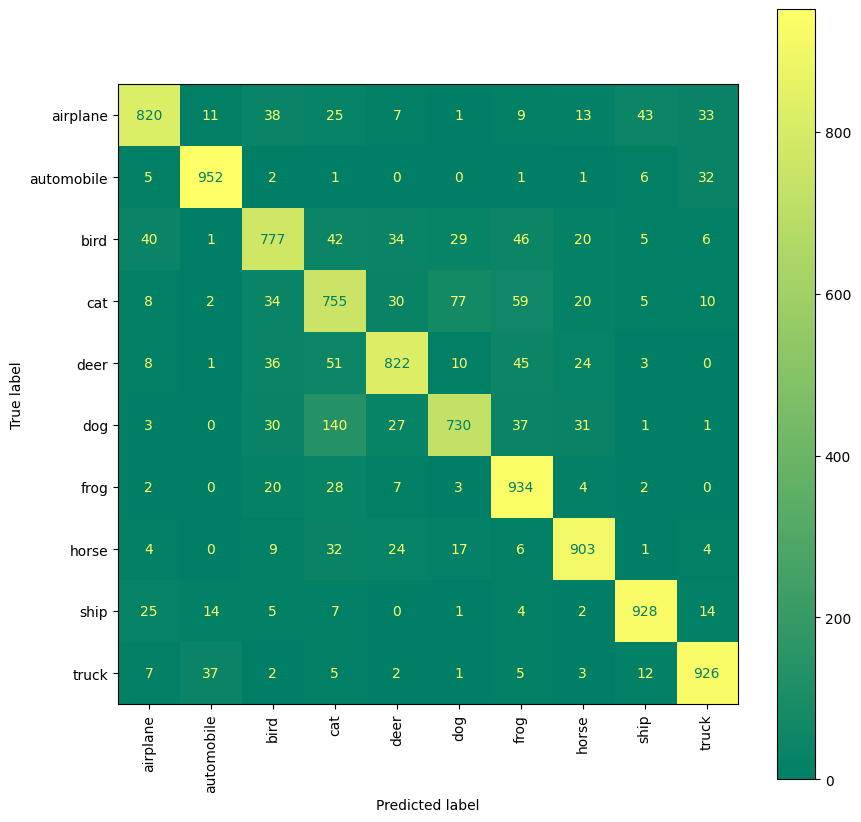

In [15]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      1000
           1       0.94      0.95      0.94      1000
           2       0.82      0.78      0.80      1000
           3       0.70      0.76      0.72      1000
           4       0.86      0.82      0.84      1000
           5       0.84      0.73      0.78      1000
           6       0.82      0.93      0.87      1000
           7       0.88      0.90      0.89      1000
           8       0.92      0.93      0.93      1000
           9       0.90      0.93      0.91      1000

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



 Image 100 is [4]
1/1 [==============================] - 1s 670ms/step
The model predict that image 100 is 4


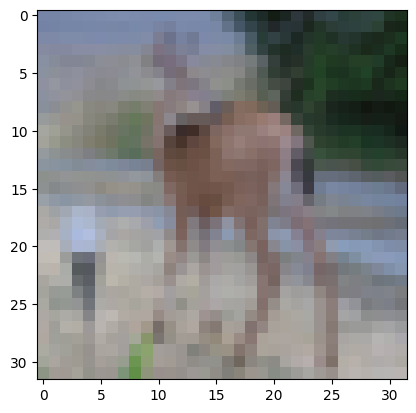

In [17]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

In [18]:
from tensorflow.keras.models import load_model

model.save('cnn_1_epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
